In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "../input/dateexpiration/data"

BATCH_SIZE = 64
IMG_SIZE = (160, 160)

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    subset="training",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.3,
)

Found 360000 files belonging to 3600 classes.
Using 252000 files for training.


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    subset="validation",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.3,
)

Found 360000 files belonging to 3600 classes.
Using 108000 files for validation.


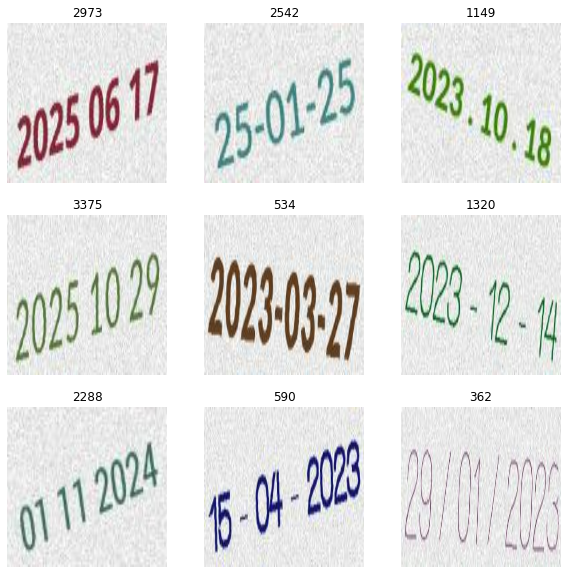

In [5]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 1351
Number of test batches: 337


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

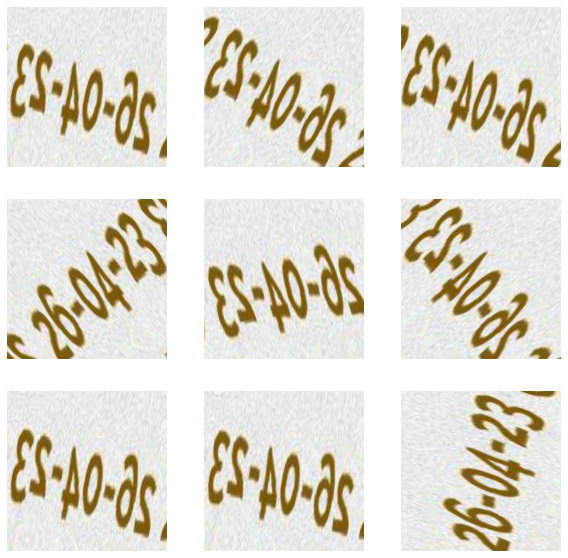

In [10]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

In [11]:
preprocessing_input = tf.keras.applications.inception_resnet_v2.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

### Base Model

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

219070464/219055592 [==============================] - 10s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 3, 3, 1536)


In [15]:
base_model.trainable = False

### add classification head

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1536)


In [17]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 3600)


In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
# x = data_augmentation(inputs)
x = preprocessing_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_lr = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_lr),
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 3600)              553320

In [21]:
len(model.trainable_variables)

2

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

1351/1351 [==============================] - 244s 144ms/step - loss: 8.3990 - accuracy: 2.6611e-04


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 8.40
initial accuracy: 0.00


In [24]:
history = model.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
    batch_size=BATCH_SIZE
)

Epoch 1/10
3938/3938 [==============================] - 729s 183ms/step - loss: 8.2730 - accuracy: 0.0013 - val_loss: 7.9204 - val_accuracy: 0.0035
Epoch 2/10
3938/3938 [==============================] - 617s 157ms/step - loss: 7.8495 - accuracy: 0.0040 - val_loss: 7.7359 - val_accuracy: 0.0052
Epoch 3/10
3938/3938 [==============================] - 624s 158ms/step - loss: 7.6205 - accuracy: 0.0069 - val_loss: 7.6043 - val_accuracy: 0.0069
Epoch 4/10
3938/3938 [==============================] - 622s 158ms/step - loss: 7.4409 - accuracy: 0.0099 - val_loss: 7.5022 - val_accuracy: 0.0080
Epoch 5/10
3938/3938 [==============================] - 623s 158ms/step - loss: 7.2981 - accuracy: 0.0124 - val_loss: 7.4179 - val_accuracy: 0.0095
Epoch 6/10
3938/3938 [==============================] - 624s 158ms/step - loss: 7.1752 - accuracy: 0.0154 - val_loss: 7.3474 - val_accuracy: 0.0106
Epoch 7/10
3938/3938 [==============================] - 610s 155ms/step - loss: 7.0674 - accuracy: 0.0182 - val_

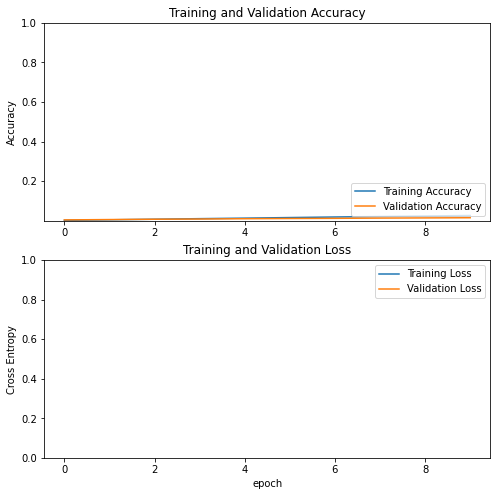

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_model.trainable = True

In [27]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  780


In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_lr/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 3, 3, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 3600)              553320

In [30]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds,
                         batch_size=BATCH_SIZE)

Epoch 10/20
3938/3938 [==============================] - 1398s 348ms/step - loss: 2.8658 - accuracy: 0.3159 - val_loss: 1.1341 - val_accuracy: 0.6419
Epoch 11/20
3938/3938 [==============================] - 1364s 346ms/step - loss: 0.8543 - accuracy: 0.7297 - val_loss: 0.1977 - val_accuracy: 0.9455
Epoch 12/20
3938/3938 [==============================] - 1361s 346ms/step - loss: 0.2617 - accuracy: 0.9168 - val_loss: 0.0775 - val_accuracy: 0.9784
Epoch 13/20
3938/3938 [==============================] - 1363s 346ms/step - loss: 0.1136 - accuracy: 0.9646 - val_loss: 0.0381 - val_accuracy: 0.9898
Epoch 14/20
3938/3938 [==============================] - 1360s 345ms/step - loss: 0.0677 - accuracy: 0.9795 - val_loss: 0.0279 - val_accuracy: 0.9924
Epoch 15/20
3938/3938 [==============================] - 1370s 348ms/step - loss: 0.0471 - accuracy: 0.9853 - val_loss: 0.0238 - val_accuracy: 0.9943
Epoch 16/20
3938/3938 [==============================] - 1361s 345ms/step - loss: 0.0353 - accuracy:

In [31]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

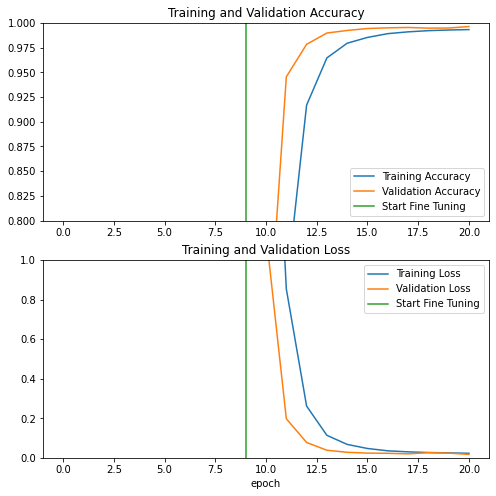

In [32]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [56]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

337/337 [==============================] - 39s 114ms/step - loss: 0.0180 - accuracy: 0.9961
Test accuracy : 0.996059000492096


In [34]:
model.save("models/inception_resnetv2_98.h5")

Predictions:
 2552
Labels:
 [2552 2373 3536  364 2029  230 3188 2001 1225   67 2459 3150 3251  981
 1782  913  326 1034 2718  165 3300 2931  457  714 3176 3423 2972 2704
 2459 1521 3298 1444  737  923 1804 1868 3258 2636 1066  912 1319 1032
 2610 1038 1037 1216  405 2379 1768 2922  593 1327  577 2596 1932 1822
  333  323 1054 1565  258 1009 2106 1321]


IndexError: invalid index to scalar variable.

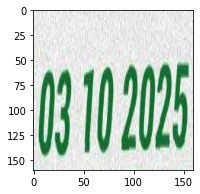

In [64]:
import numpy as np
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict(image_batch)

# Apply a sigmoid since our model returns logits
predictions = np.argmax(predictions)
# predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [37]:
# create label
from datetime import datetime, timedelta
from collections import OrderedDict

def gen_date(start, end):
    date_generated = [start + timedelta(days=x) for x in range(0, (end-start).days)]
    return date_generated


def parse_date(delimiter, base_format):
    dates = []
    for i in delimiter:
        date = base_format.replace("-", i)
        dates.append(date)
    return dates


def date_gen_format(date, format):
    try:
        date = datetime.strftime(date, format)
        return date
    except ValueError:
        pass

In [51]:
labels = []

delimiter = ("", " ", "-", " - ", "/", " / ", ".", " . ")

base_format = ["%d-%m-%y", "%d-%m-%Y", "%Y-%m-%d"]

start = datetime(2022, 10, 1)
end = datetime(2025, 12, 31)

x = 1
for date in gen_date(start, end):
    for i in base_format:
        # for j in parse_date(delimiter, i):
        labels.append(date_gen_format(date, i))
    x += 1

month = list(OrderedDict(((start + timedelta(_)).strftime(r"%b%y"), None) for _ in range((end - start).days)).keys())
for i in month:
    labels.append(i)
    x += 1
        

In [52]:
len(labels)

3600

In [ ]:
for i in predictions:
    print(labels[np.argmax(i)])
    

In [ ]:
with open("date_exp_labels.txt", "w") as f:
    for i in class_names:
        for n, name in enumerate(labels):
            if int(i) == n:
                f.write(name + "\n")

In [140]:
llabels = []
for i in class_names:
    for n, name in enumerate(labels):
        if int(i) == n:
            llabels.append(name)

In [153]:
llabels[1]

'04-10-2022'

In [ ]:
predictions = model.predict(test_ds)
for i in predictions:
    print(llabels[np.argmax(i)])
    

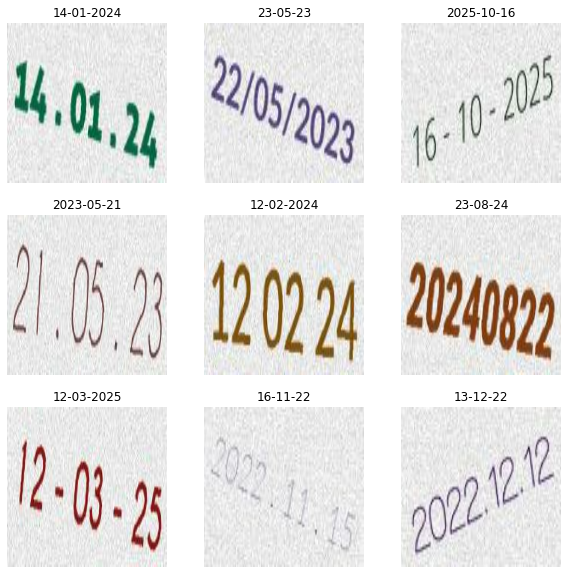

In [154]:
plt.figure(figsize=(10, 10))
for images, label in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
#         pred = [llabels[np.argmax(k)] for k in predictions]
        plt.title(llabels[label[i]])
        plt.axis("off")